In [2]:
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import json

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)



## Understanding the Dataset

Some outputs are removed form the notebook to protect proprietal information. This section codes functions to aid with the understanding and observation of the raw dataset.

In [4]:
pd.set_option('display.max_columns', None)
df=pd.read_csv('path to input dataset/file.csv', encoding='ISO-8859-1')
df_describe=df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29344 entries, 0 to 29343
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Discipline      29344 non-null  object
 1   Module Name     29344 non-null  object
 2   Module UID      29344 non-null  object
 3   Requirement ID  29344 non-null  object
 4   Object Type     29194 non-null  object
 5   Object Text     29234 non-null  object
dtypes: object(6)
memory usage: 1.3+ MB


### Comments on the dataset:
From the pandas description, the following observations are made:
* Total size of the dataset are circa 30K requirements.
* There are 3 unique disciplines as tagged in the DXL script.
* There are a total of 17200 unique Object Texts, indicating duplication. This is expected since there is an overlap with 2 of the disciplines. This is specially true across Module Name category (since some of the different contracts across across a given discipline contain the same requirements) but also holds across both disciplines. The classification distinction between these 2 disciplines is hard and ambiguous, so we group these 2 disciplines in to two.
* There are a total of 29 Unique Module Names
* Module Unique identifier contains an apostrophe to cope with csv format and contains alphanumerical characters.
* Object Type contains 7 unique labels.

### What do we need for training?
* We are going to be classifying the Object Text according to the Object Type and Discipline labels.

For Req-BERTA there are 3 problems we are solving:
1) Problem 1: Binary classification of "Object Text" using the "Object Type" label (Functional Requirement, Non-Functional Requirement) classes.
2) Problem 2: Binary classification of "Object Text" using the "Discipline" Label (0, 1)
3) Problem 3: Multilabel classification of "Object Text" using "Object Type" and "Discipline labels".

### Actions to perform on the dataset:
1) Remove duplicated values of Object Texts
2) Normalize the Discipline label: "Construction" and "Rail Systems"
3) Normalize the Object Type label: "Functional Requirement" and "Non-Functional Requirement"
4) Split the data into Training, Validation, and Testing. We chose a ration of 70-30 for Training and Testing, and 20% of the training data for validation of hyperparameter selection.

## Plots of the raw data

In [ ]:
import matplotlib.pyplot as plt

#Defefinitions of Functions to Plot the data. Outputs removed.

#Func 1: Object Type attribute plots, This is FR vs NFR problem after cleansing.
def plot_ObjTypDisc(df_name):
    plt.figure(1, figsize=(10, 8))

    # Plot Object Type
    plt.subplot(2, 2, 1)
    object_type_counts = df_name['Object Type'].value_counts().sort_values()
    object_type_counts.plot(kind='bar', color='darkgreen')  # Set darker bar color
    plt.title('Object Type')
    plt.xlabel('Object Type')
    plt.ylabel('Object Count')
    #plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
    plt.gca().set_axisbelow(True)

    # Add count values on each bar for Object Type
    for i, count in enumerate(object_type_counts):
        plt.text(i, count, str(count), ha='center', va='bottom')

    # Plot Discipline
    plt.subplot(2, 2, 2)
    discipline_counts = df_name['Discipline'].value_counts().sort_values()
    discipline_counts.plot(kind='bar', color='darkgreen')  # Set darker bar color
    plt.title('Discipline')
    plt.xlabel('Discipline')
    plt.ylabel('Object Count')
    #plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
    plt.gca().set_axisbelow(True)
    plt.tick_params(axis='x', rotation=0)

    # Add count values on each bar for Discipline
    for i, count in enumerate(discipline_counts):
        plt.text(i, count, str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

#Func 2: plot the distribution of Object Type per concatenated document.
def plot_Contracts(df_name):
    plt.figure(0, figsize=(15, 8))
    contracts_sorted = df_name['Module Name'].value_counts().sort_values()
    contracts_sorted.plot(kind='bar', color='darkgreen')
    plt.title('Contracts')
    plt.xlabel('Object Type')
    plt.ylabel('Contract')
    plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
    plt.gca().set_axisbelow(True)
    plt.tick_params(axis='x', rotation=90)
    # Add count values on each bar for Discipline
    for i, count in enumerate(contracts_sorted):
        plt.text(i, count, str(count), ha='center', va='bottom')
        plt.show()

#Func 3: Plot the Discipline per concatenated document.
def plot_contracts_leg(df_name):
    # Get unique values of the "Discipline" column
    disciplines = df_name['Discipline'].unique()

    # Create a custom color map for each unique discipline
    colors = plt.cm.get_cmap('Dark2', len(disciplines))

    plt.figure(0, figsize=(15, 8))

    # Iterate over the unique disciplines
    for i, discipline in enumerate(disciplines):
        # Filter the data for each discipline
        filtered_data = df_name[df_name['Discipline'] == discipline]
        # Get the count values for each unique module name and sort them
        module_counts = filtered_data['Module Name'].value_counts().sort_values(ascending=True)
        # Plot the bars with the corresponding color
        plt.bar(module_counts.index, module_counts.values, color=colors(i))

    plt.title('Contracts')
    plt.xlabel('Module Name')
    plt.ylabel('Count')
    plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
    plt.gca().set_axisbelow(True)
    plt.tick_params(axis='x', rotation=90)

    # Create the custom color legend
    legend_colors = [colors(i) for i in range(len(disciplines))]
    legend_labels = disciplines

    # Plot the color legend
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=c) for c in legend_colors]
    plt.legend(legend_handles, legend_labels, title='Discipline')
    
    plt.tight_layout()
    plt.show()

#Function 4: Variation of Function 3 to plot Discipline per concatenated document in ascending order.
def plot_contracts_leg2(df_name):
    # Get the count values for each unique module name
    module_counts = df_name['Module Name'].value_counts()

    # Sort the module counts in ascending order
    sorted_module_counts = module_counts.sort_values(ascending=True)

    # Get unique values of the "Discipline" column
    disciplines = df_name['Discipline'].unique()

    # Create a custom color map for each unique discipline
    colors = plt.cm.get_cmap('Dark2', len(disciplines))

    plt.figure(0, figsize=(15, 8))

    # Assign a color to each discipline using the custom color map
    color_map = {discipline: colors(i) for i, discipline in enumerate(disciplines)}

    # Plot the bars with the corresponding color based on discipline
    for module_name, count in sorted_module_counts.items():
        discipline = df_name[df_name['Module Name'] == module_name]['Discipline'].values[0]
        color = color_map[discipline]
        plt.bar(module_name, count, color=color)

    plt.title('Contracts')
    plt.xlabel('Module Name')
    plt.ylabel('Count')
    plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
    plt.gca().set_axisbelow(True)
    plt.tick_params(axis='x', rotation=90)

    # Create the custom color legend
    legend_colors = [color_map[discipline] for discipline in disciplines]
    legend_labels = disciplines

    # Plot the color legend
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=c) for c in legend_colors]
    plt.legend(legend_handles, legend_labels, title='Discipline')

    plt.tight_layout()
    plt.show()

#Function 5: plot the Object Tyoe per concatenated document.

def plot_contracts_objTyp(df_name):
    # Exclude rows with missing values in 'Object Type' column
    df_filtered = df_name.dropna(subset=['Object Type'])

    # Group the filtered data by Module Name and Object Type, and calculate the counts
    grouped_data = df_filtered.groupby(['Module Name', 'Object Type']).size().unstack(fill_value=0)

    # Sort the module counts in ascending order based on the total counts across all Object Types
    sorted_module_counts = grouped_data.sum(axis=1).sort_values(ascending=True)

    # Get the unique Object Types
    object_types = df_filtered['Object Type'].unique()

    # Create a custom color map for each unique Object Type
    colors = plt.cm.get_cmap('Dark2', len(object_types))

    plt.figure(0, figsize=(15, 8))

    # Assign a color to each Object Type using the custom color map
    color_map = {object_type: colors(i) for i, object_type in enumerate(object_types)}

    # Initialize the bottom values for each stacked bar
    bottom = np.zeros(len(sorted_module_counts))

    # Plot the stacked bars with the corresponding color based on Object Type
    for object_type in object_types:
        counts = grouped_data[object_type].loc[sorted_module_counts.index]
        color = color_map[object_type]
        plt.bar(sorted_module_counts.index, counts, bottom=bottom, color=color, label=object_type)
        bottom += counts

    plt.title('Contracts')
    plt.xlabel('Module Name')
    plt.ylabel('Count')
    plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
    plt.gca().set_axisbelow(True)
    plt.tick_params(axis='x', rotation=90)

    # Plot the custom color legend for Object Type
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[object_type]) for object_type in object_types]
    plt.legend(legend_handles, object_types, title='Object Type')

    plt.tight_layout()
    plt.show()


def plot_contracts_by_discipline(df_name):
    # Exclude rows with missing values in 'Object Type' column
    df_filtered = df_name.dropna(subset=['Object Type'])

    # Group the filtered data by Discipline and Object Type, and calculate the counts
    grouped_data = df_filtered.groupby(['Discipline', 'Object Type']).size().unstack(fill_value=0)

    # Sort the discipline counts in ascending order based on the total counts across all Object Types
    sorted_discipline_counts = grouped_data.sum(axis=1).sort_values(ascending=True)

    # Get the unique Object Types
    object_types = df_filtered['Object Type'].unique()

    # Create a custom color map for each unique Object Type
    colors = plt.cm.get_cmap('Dark2', len(object_types))

    plt.figure(0, figsize=(6, 5))

    # Assign a color to each Object Type using the custom color map
    color_map = {object_type: colors(i) for i, object_type in enumerate(object_types)}

    # Initialize the bottom values for each stacked bar
    bottom = np.zeros(len(sorted_discipline_counts))

    # Set the width of the bars
    bar_width = 1.8 / len(object_types)

    # Plot the stacked bars with the corresponding color based on Object Type
    for object_type in object_types:
        counts = grouped_data[object_type].loc[sorted_discipline_counts.index]
        color = color_map[object_type]
        plt.bar(sorted_discipline_counts.index, counts, bottom=bottom, width=bar_width, color=color, label=object_type)
        bottom += counts

    plt.title('Contracts by Discipline')
    plt.xlabel('Discipline')
    plt.ylabel('Count')
    plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
    plt.gca().set_axisbelow(True)

    # Plot the custom color legend for Object Type
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[object_type]) for object_type in object_types]
    plt.legend(legend_handles, object_types, title='Object Type')

    plt.tight_layout()
    plt.show()

In [ ]:
#Call the Functions.

plot_ObjTypDisc(df)

plot_Contracts(df)

plot_contracts_leg(df)


plot_contracts_leg2(df)

plot_contracts_objTyp(df)

plot_contracts_by_discipline(df)

## Cleaning the Data

This section cleans the dataset for the Models. Some outputs are removed to protect Propriety data.

#### Print the classes

In [ ]:
def get_unique_values(df_name):
    unique_object_types = df_name['Object Type'].unique()
    unique_disciplines = df_name['Discipline'].unique()
    unique_module_ids = df_name['Module Name'].unique()

    print("Unique Object Types:")
    print(unique_object_types)
    print()

    print("Unique Disciplines:")
    print(unique_disciplines)
    print()

    print("Unique Module IDs:")
    print(unique_module_ids)

  

get_unique_values(df)


#### Print the count of classes

In [ ]:
#Function to print unique value counts of each label.
def print_value_counts(column, df):
    print(f"Count of values for column '{column}':")
    print('---------------------------------------')  
    value_counts = df[column].value_counts()
    for value, count in value_counts.items():
        print(f"{value}: {count}")
    print('---------------------------------------')  # Add an empty line after printing the counts

    
print_value_counts('Object Type',df)
print_value_counts('Discipline',df)
print_value_counts('Module Name',df)

### Clean the enumerations
Below the data cleansing process begins:
Bias has been carefully considered for the object type, where Information is treated as an Non Functional Requirement, and Requirement as a Functional Requirement. The rest are admin types. For the deleted cases, it is not straightforward to know if they where Functional or Non funtional before deletion without advanced DXL scripting and the benefit would be minimal.
In terms of the Discipline normalisation we group 2 classes as earlier described.

In [ ]:
filtered_df = df[~df['Object Type'].isin(['nan', 'Heading', 'DELETED', 'Deleted', 'CRT Text'])] #Get rid of Nan values, and placehodler values of Object Type, so only values are Requirement (Functional Requirement) and Information (Non-Functional Requirement)
filtered_df.loc[filtered_df['Object Type'].str.contains('Guidance', na=False), 'Object Type'] = 'Information'
filtered_df['Discipline'].replace(['Civils', 'Stations'], 'Construction', inplace=True) #Group the ambiguous discipline classes
filtered_df = filtered_df.dropna(how='any') #Drop all NAN values

get_unique_values(filtered_df)

In [ ]:
print_value_counts('Object Type',filtered_df)
print_value_counts('Discipline',filtered_df)
print_value_counts('Module Name',filtered_df)

### Remove duplicated targets

In [ ]:
def remove_duplicates(df_input):
    # Group by "Object Text" and concatenate the values in other columns
    grouped_df = df_input.groupby('Object Text').agg({
        'Discipline': 'first',
        'Module Name': lambda x: list(x),
        'Module UID': lambda x: list(x),
        'Requirement ID': lambda x: list(x),
        'Object Type': 'first'
    }).reset_index()

    return grouped_df

df_cleaned=remove_duplicates(filtered_df)
df_cleaned.head()

### Training and Test Dataset: Roberta

In [18]:
## For Roberta
# Splitting the dataset into training (80%) and testing (20%)
train_preval_df, test_df = train_test_split(df_cleaned, test_size=0.2, stratify=df_cleaned[['Discipline', 'Object Type']])

#Take 20% of the Training data for validation of hyperparameter tuning
train_df, val_df = train_test_split(train_preval_df, test_size=0.2, stratify=train_preval_df[['Discipline', 'Object Type']])
# Print the shape of the training and testing datasets
print("Training dataset shape:", train_df.shape)
print("Validation dataset shape:", val_df.shape)
print("Testing dataset shape:", test_df.shape)

Training dataset shape: (9542, 6)
Validation dataset shape: (2386, 6)
Testing dataset shape: (2983, 6)


#### Map the labels into integers

In [19]:
def discretize_dataframe(input_df):
    # Create a copy of the input DataFrame
    disc_df = input_df.copy()

    # Create a dictionary to store column mappings
    column_mapping = {}

    # Iterate over the columns to be normalized
    columns_to_normalize = ['Object Type', 'Discipline']
    for column in columns_to_normalize:
        # Create a dictionary mapping for the current column
        column_mapping[column] = {value: index for index, value in enumerate(disc_df[column].dropna().unique())}
        
        # Update the column values in the normalized DataFrame
        disc_df[column] = disc_df[column].map(column_mapping[column])

    # Print the column mappings
    for column, mapping in column_mapping.items():
        print(f"Mapping for '{column}': {mapping}")

    return disc_df

train_df_disc=discretize_dataframe(train_df)
test_df_disc=discretize_dataframe(test_df)
val_df_disc=discretize_dataframe(val_df)


Mapping for 'Object Type': {'Requirement': 0, 'Information': 1}
Mapping for 'Discipline': {'Rail Systems': 0, 'Construction': 1}
Mapping for 'Object Type': {'Requirement': 0, 'Information': 1}
Mapping for 'Discipline': {'Construction': 0, 'Rail Systems': 1}
Mapping for 'Object Type': {'Information': 0, 'Requirement': 1}
Mapping for 'Discipline': {'Rail Systems': 0, 'Construction': 1}


In [194]:
train_df_disc.to_csv('/Users/alangilliland/Documents/Work/Msc/ResearchProject/Datasets/HS2_DATASET/V2/train_data.csv', index=False)
test_df_disc.to_csv('/Users/alangilliland/Documents/Work/Msc/ResearchProject/Datasets/HS2_DATASET/V2/test_data.csv', index=False)
val_df_disc.to_csv('/Users/alangilliland/Documents/Work/Msc/ResearchProject/Datasets/HS2_DATASET/V2/val_data.csv', index=False)

Mapping for 'Object Type': {'Information': 0, 'Requirement': 1}
Mapping for 'Discipline': {'Rail Systems': 0, 'Construction': 1}


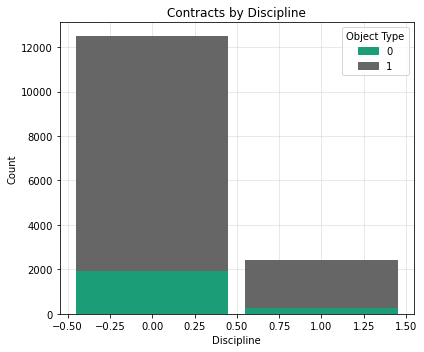

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14911 entries, 0 to 14910
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Object Text     14911 non-null  object
 1   Discipline      14911 non-null  int64 
 2   Module Name     14911 non-null  object
 3   Module UID      14911 non-null  object
 4   Requirement ID  14911 non-null  object
 5   Object Type     14911 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 699.1+ KB


In [24]:
df_cleaned_plot=discretize_dataframe(df_cleaned)
plot_contracts_by_discipline(df_cleaned_plot)
df_cleaned_plot.info()

### Convert it to JSON format for LLAMA

In [212]:
def convert_dataframe_to_json(input_df):
    # Remove the specified columns
    columns_to_remove = ['Module Name', 'Module UID', 'Requirement ID']
    df = input_df.drop(columns_to_remove, axis=1)
    
    # Convert the remaining data to JSON
    json_data = []
    for _, row in df.iterrows():
        obj_text = row['Object Text']
        obj_type = row['Object Type']
        discipline = row['Discipline']
        
        data = {
            "instruction": obj_text,
            "input": "",
            "output": f"{obj_type}, {discipline}"
        }
        
        json_data.append(data)
    
    # Convert the list of dictionaries to JSON string without escape characters
    json_string = json.dumps(json_data, indent=4, ensure_ascii=False)
    
    return json_string

train_json_llama = convert_dataframe_to_json(train_json_llama_df)
test_json_llama = convert_dataframe_to_json(test_json_llama_df)

llama_train_path = 'output path/train.json'
llama_test_path = 'output path/test.json'

# Save the JSON to the specified file path
with open(llama_train_path, 'w', encoding='utf-8') as f:
    f.write(train_json_llama)

# Save the JSON to the specified file path
with open(llama_test_path, 'w', encoding='utf-8') as f:
    f.write(test_json_llama)

In [213]:
test_json_llama_df.to_csv('/Users/alangilliland/Documents/Work/Msc/ResearchProject/Datasets/HS2_DATASET/V2/test.csv', index=False)